FISHEYE IMAGE

In [51]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import json
import math

In [3]:
from hole_data import hole_data, post_hole_data

IMAGES WITH HOLE DATA

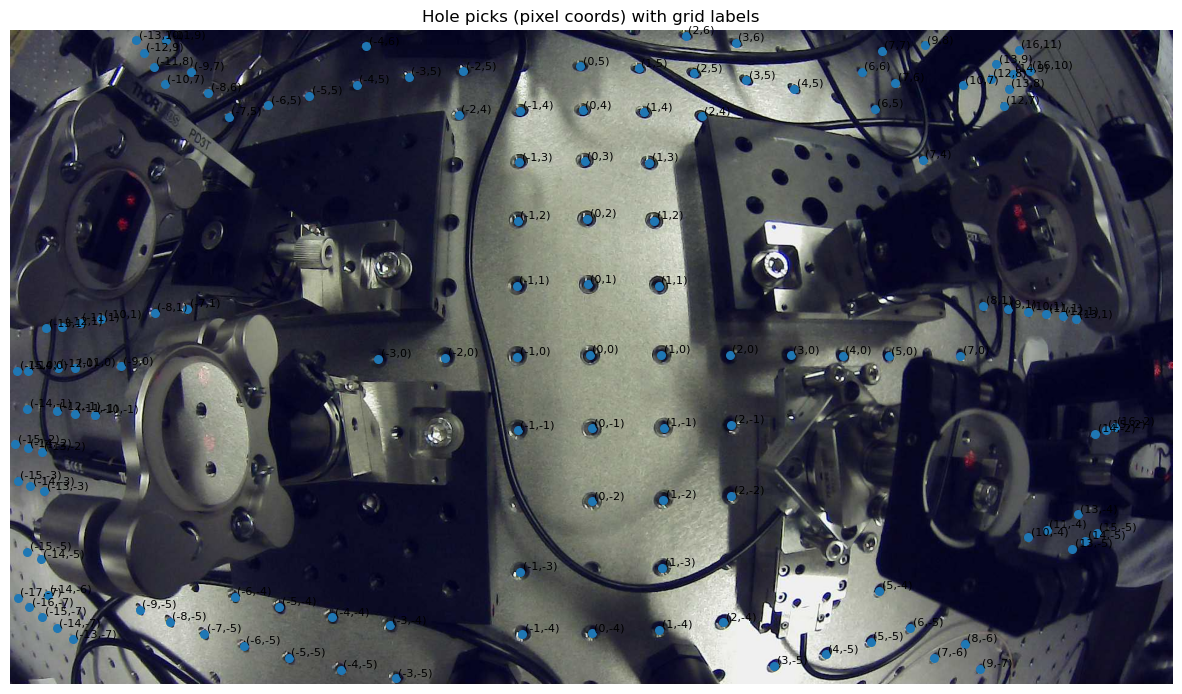

In [5]:
# --- your inputs ---
img_path = "Fisheye_Image.jpg"

# Convert to arrays
hd = np.array(hole_data, dtype=float)  # shape (N, 4)
xg, yg, u, v = hd[:,0], hd[:,1], hd[:,2], hd[:,3]  # grid coords and pixel coords

# Load image (BGR->RGB for matplotlib)
img_bgr = cv.imread(img_path)
assert img_bgr is not None, f"Could not read image at {img_path}"
img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)

# Plot
plt.figure(figsize=(15, 15))
plt.imshow(img_rgb)                      # origin is top-left, matches your (u,v)
plt.scatter(u, v, s=30, marker='o')      # overlay points

# Add text labels with the grid coords (xg, yg)
for xi, yi, ui, vi in zip(xg, yg, u, v):
    plt.text(ui+4, vi-4, f"({int(xi)},{int(yi)})", fontsize=8)

plt.title("Hole picks (pixel coords) with grid labels")
plt.axis('off')
plt.show()

OPTICAL POST DATA

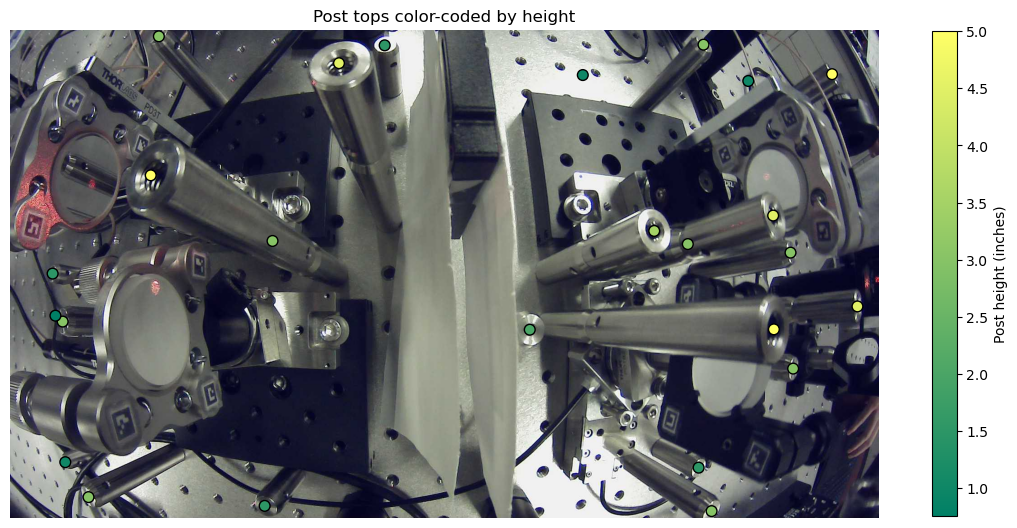

In [7]:
post_hole_data = np.array(post_hole_data, dtype=float)

# Pixel coords (u, v) and height
u = post_hole_data[:, 2]   # x in image
v = post_hole_data[:, 3]   # y in image
h = post_hole_data[:, 4]   # height in inches

# Load image
img = cv.imread("Tall_posts.jpg")
assert img is not None, "Could not read Cam_Opt.jpg"
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Plot
plt.figure(figsize=(14, 14))
plt.imshow(img_rgb)
sc = plt.scatter(u, v, c=h, s=60, edgecolors='black', linewidths=1.0, cmap='summer')

cbar = plt.colorbar(sc, shrink=0.45)
cbar.set_label("Post height (inches)", rotation=90)

plt.title("Post tops color-coded by height")
plt.axis('off')
plt.show()

CAMERA INTRINSICS IMPORT

In [9]:
intrinsics_path = r"C:\Users\alber\Documents\hardware_project\intrinsics_fisheye.json"

with open(intrinsics_path, "r") as f:
    intr = json.load(f)

K = np.array(intr["K"], dtype=np.float64)
D = np.array(intr["D"], dtype=np.float64)  # shape (N,1) or (1,N) is fine
img_w = intr["image_width"]
img_h = intr["image_height"]

print("K =\n", K)
print("D =\n", D.ravel())


K =
 [[800.10950702   0.         897.3372803 ]
 [  0.         798.26026625 564.86743566]
 [  0.           0.           1.        ]]
D =
 [ 4.81139317e-01  2.88287471e-02 -6.77310011e-05 -1.80131062e-04
  0.00000000e+00  8.21775614e-01  1.17828974e-01  1.48619175e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


In [10]:
obj_xyz = []
img_uv  = []

# Table holes: Z = 0
for X, Y, u, v in hole_data:
    obj_xyz.append([X, Y, 0.0])
    img_uv.append([u, v])

# Post tops: Z = H
for X, Y, u, v, H in post_hole_data:
    obj_xyz.append([X, Y, H])
    img_uv.append([u, v])

obj_xyz = np.array(obj_xyz, dtype=np.float64)
img_uv  = np.array(img_uv,  dtype=np.float64)

print("Using", obj_xyz.shape[0], "points for pose estimation.")

success, rvec_cw, tvec_cw = cv.solvePnP(
    objectPoints=obj_xyz,
    imagePoints=img_uv,
    cameraMatrix=K,
    distCoeffs=D,
    flags=cv.SOLVEPNP_ITERATIVE
)

if not success:
    raise RuntimeError("solvePnP failed")

R_cw, _ = cv.Rodrigues(rvec_cw)  # world -> camera
t_cw = tvec_cw                   # 3x1

R_wc = R_cw.T                    # camera -> world
t_wc = -R_wc @ t_cw              # camera center in world coords

print("R_cw =\n", R_cw)
print("t_cw =", t_cw.ravel())
print("camera center (world) =", t_wc.ravel())

Using 160 points for pose estimation.
R_cw =
 [[ 0.99990961 -0.01041977 -0.00849736]
 [-0.01113736 -0.99594189 -0.08930679]
 [-0.00753232  0.08939335 -0.99596792]]
t_cw = [ 0.49586398 -0.22529675  6.61173178]
camera center (world) = [-0.44852669 -0.81026056  6.56916574]


TRANSITION FUNCTIONS

In [12]:
def pixel_to_world_on_plane(u, v, H_in=0.0, override_cam_height=None):
    pts = np.array([[[u, v]]], dtype=np.float64)
    rays_norm = cv.undistortPoints(pts, K, D)  # pinhole model
    x, y = rays_norm[0,0]
    d_cam = np.array([x, y, 1.0], dtype=np.float64)

    d_w = R_wc @ d_cam

    C_w = t_wc.reshape(3).copy()
    if override_cam_height is not None:
        C_w[2] = float(override_cam_height)

    lam = (H_in - C_w[2]) / d_w[2]
    Pw = C_w + lam * d_w
    return float(Pw[0]), float(Pw[1])

In [13]:
def world_to_pixel(X, Y, Z):
    obj = np.array([[[X, Y, Z]]], dtype=np.float64)  # (1,1,3)
    img_proj, _ = cv.projectPoints(obj, rvec_cw, tvec_cw, K, D)
    u, v = img_proj.reshape(2)
    return float(u), float(v)

In [14]:
# After you computed R_wc, t_wc:
C_w = t_wc.flatten()           # camera center in world units (inches)
est_height = abs(C_w[2])       # distance from table plane Z=0
print(f"Estimated camera height ≈ {est_height:.3f} inches")

Estimated camera height ≈ 6.569 inches


READING ARUCOS

[detect] Found 12 candidate markers using DICT_4X4_100
[filter] Kept 12 markers from allowed IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


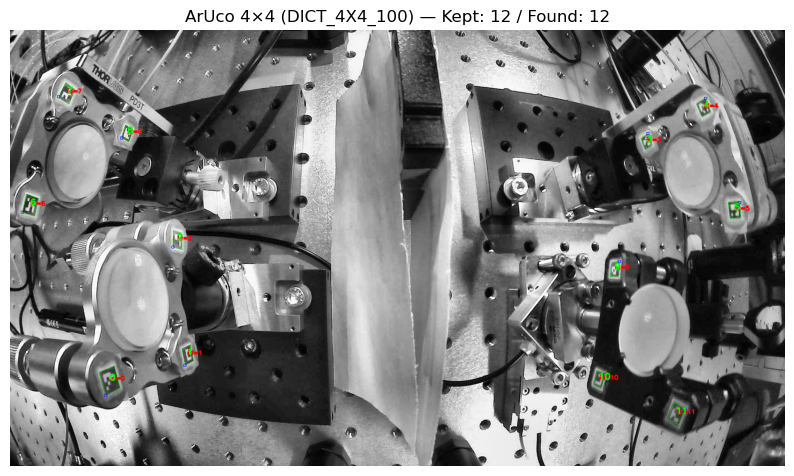

[out] Ready: detected list with 12 kept markers (ids, corners, centers).
  id=0, center=[247.01825714 867.45246887], TL=[236.64160156 904.89044189]
  id=10, center=[1459.418396    865.10101318], TL=[1473.  853.]
  id=6, center=[ 50.2206831  433.56534576], TL=[ 29.70200348 450.88851929]
  id=11, center=[1650.86312866  950.1179657 ], TL=[1672.  938.]
  id=7, center=[141.1205616  156.25066757], TL=[120.20059967 165.16400146]


In [16]:
# Config
img_path = "laser_reflec_light2.jpg"   # set your image path
dict_name = "DICT_4X4_100"                 # choose your 4x4 family: DICT_4X4_50/100/250/1000
allowed_ids = {0,1,2,3,4,5,6,7,8,9,10,11}   # <<< replace with YOUR printed IDs
use_CLAHE = True                           # True: local equalization; False: global hist eq
resize_factor = 1.0                         # e.g., 1.5 if markers are tiny/pixelated

# Load + grayscale + enhance
img_bgr = cv.imread(img_path)
assert img_bgr is not None, f"Could not read image at {img_path}"
gray = cv.cvtColor(img_bgr, cv.COLOR_BGR2GRAY)

# Optional upsample for tiny markers
if resize_factor != 1.0:
    gray = cv.resize(gray, None, fx=resize_factor, fy=resize_factor, interpolation=cv.INTER_CUBIC)
    img_bgr = cv.resize(img_bgr, None, fx=resize_factor, fy=resize_factor, interpolation=cv.INTER_CUBIC)

# Contrast enhancement
if use_CLAHE:
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray_eq = clahe.apply(gray)
else:
    gray_eq = cv.equalizeHist(gray)

# ArUco detection (4x4 dict)
aruco_dict = cv.aruco.getPredefinedDictionary(getattr(cv.aruco, dict_name))

# Detector parameters (tuned for small/low-contrast markers)
try:
    params = cv.aruco.DetectorParameters()
except AttributeError:
    params = cv.aruco.DetectorParameters_create()

params.adaptiveThreshWinSizeMin = 3
params.adaptiveThreshWinSizeMax = 45
params.adaptiveThreshWinSizeStep = 3
params.adaptiveThreshConstant   = 7
params.minMarkerPerimeterRate   = 0.01
params.maxMarkerPerimeterRate   = 5.0
params.minCornerDistanceRate    = 0.01
params.cornerRefinementMethod   = cv.aruco.CORNER_REFINE_SUBPIX

# Detect (handle both new/old OpenCV APIs)
try:
    detector = cv.aruco.ArucoDetector(aruco_dict, params)
    corners, ids, rejected = detector.detectMarkers(gray_eq)
except AttributeError:
    corners, ids, rejected = cv.aruco.detectMarkers(gray_eq, aruco_dict, parameters=params)

total_found = 0 if ids is None else len(ids)
print(f"[detect] Found {total_found} candidate markers using {dict_name}")

# Filter to allowed_ids
filtered_corners, filtered_ids = [], []
rejected_by_id = []  # for visualization/debug

if ids is not None:
    for c, i in zip(corners, ids.flatten()):
        if int(i) in allowed_ids:
            filtered_corners.append(c)
            filtered_ids.append([int(i)])   # keep as nested list for OpenCV
        else:
            rejected_by_id.append((c, int(i)))

if len(filtered_ids) == 0:
    print("[filter] No allowed markers detected!")
else:
    print(f"[filter] Kept {len(filtered_ids)} markers from allowed IDs: {sorted(allowed_ids)}")

# Convert to numpy for downstream OpenCV calls
ids_kept = np.array(filtered_ids, dtype=np.int32) if filtered_ids else None
corners_kept = filtered_corners

# Build a nice visualization
#   - green boxes = kept (allowed)
#   - red boxes   = rejected-by-ID (optional)
vis = cv.cvtColor(gray_eq, cv.COLOR_GRAY2RGB)

# Draw kept markers in green
if ids_kept is not None and len(ids_kept) > 0:
    cv.aruco.drawDetectedMarkers(vis, corners_kept, ids_kept)
    for c, i in zip(corners_kept, ids_kept.flatten()):
        center = c.reshape(-1,2).mean(axis=0).astype(int)
        cv.putText(vis, f"{int(i)}", tuple(center), cv.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2, cv.LINE_AA)

# Optionally draw rejected-by-ID in red (helps you see the false positive)
for c, i in rejected_by_id:
    pts = c.reshape(4,2).astype(int)
    cv.polylines(vis, [pts], True, (255,0,0), 2, cv.LINE_AA)
    center = pts.mean(axis=0).astype(int)
    cv.putText(vis, f"rej {int(i)}", tuple(center), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2, cv.LINE_AA)

plt.figure(figsize=(10,10))
plt.imshow(vis)
plt.title(f"ArUco 4×4 ({dict_name}) — Kept: {0 if ids_kept is None else len(ids_kept)} / Found: {total_found}")
plt.axis('off')
plt.show()

# Collect outputs for downstream use
detected = []
if ids_kept is not None:
    for c, i in zip(corners_kept, ids_kept.flatten()):
        pts = c.reshape(4,2).astype(float)    # TL, TR, BR, BL
        center = pts.mean(axis=0)
        # If you upsampled (resize_factor != 1), pts/center are already in the resized pixel space.
        # If you want original-image coordinates instead, divide by resize_factor here.
        detected.append({"id": int(i), "corners": pts, "center": center})

print(f"[out] Ready: detected list with {len(detected)} kept markers (ids, corners, centers).")
# Example peek:
for d in detected[:5]:
    print(f"  id={d['id']}, center={d['center']}, TL={d['corners'][0]}")

FINDING CENTER OF MIRROR 1

In [18]:
heights = {0: 4.722167,
    1: 3.4291,
    2: 3.4210290000000003,
    3: 3.471474,
    4: 4.776629,
    5: 4.76645,
    6: 4.774986,
    7: 4.780836,
    8: 3.47397,
    9: 3.32363,
    10: 3.280905,
    11: 4.705506000000001}

In [19]:
def get_center_for_id(detected, tag_id):
    for d in detected:
        if d["id"] == tag_id:
            return float(d["center"][0]), float(d["center"][1])  # (u,v)
    raise ValueError(f"Marker ID {tag_id} not found")

def world_point_from_id(tag_id, detected):
    u, v = get_center_for_id(detected, tag_id)
    H = heights[tag_id]
    X, Y = pixel_to_world_on_plane(u, v, H_in=H, override_cam_height=None)
    return np.array([X, Y, H], dtype=np.float64)

def mirror_center_from_ids(id0, id1, id2):

    P0 = world_point_from_id(id0, detected)
    P1 = world_point_from_id(id1, detected)
    P2 = world_point_from_id(id2, detected)

    M = 0.5 * (P0 + P2)

    return M

In [20]:
def offset_point_negative_x(id0, id1, id2, neg=True, offset=0.045):
    P0 = world_point_from_id(id0, detected)
    P1 = world_point_from_id(id1, detected)
    P2 = world_point_from_id(id2, detected)
    M = 0.5*(P0 + P2)

    # Plane normal (not normalized)
    n = np.cross(P1 - P0, P2 - P0)
    n_norm = np.linalg.norm(n)
    if n_norm < 1e-9:
        raise ValueError("Points are collinear — no plane normal.")
    n_hat = n / n_norm   # unit normal

    # Choose the normal pointing in negative x direction
    if neg == True:
        if n_hat[0] < 0:
            n_use = n_hat
        else:
            n_use = -n_hat
    else:
        if n_hat[0] < 0:
            n_use = -n_hat
        else:
            n_use = n_hat

    P_offset = M + offset * n_use

    return P_offset

In [21]:
P0 = world_point_from_id(0, detected)
P1 = world_point_from_id(1, detected)
P2 = world_point_from_id(2, detected)

P3 = world_point_from_id(3, detected)
P4 = world_point_from_id(4, detected)
P5 = world_point_from_id(5, detected)

P6 = world_point_from_id(6, detected)
P7 = world_point_from_id(7, detected)
P8 = world_point_from_id(8, detected)

P9 = world_point_from_id(9, detected)
P10 = world_point_from_id(10, detected)
P11 = world_point_from_id(11, detected)
print(P0, P1, P2)

[-2.53542281 -1.58790956  4.722167  ] [-2.55104165 -1.59281396  3.4291    ] [-2.68949245 -0.29404271  3.421029  ]


In [22]:
M1_C_Re = offset_point_negative_x(0,1,2)
M2_C_Re = offset_point_negative_x(3,4,5, neg=False)
M3_C_Re = offset_point_negative_x(6,7,8)
M4_C_Re = mirror_center_from_ids(9,10,11)

In [23]:
M1_C_Px = world_to_pixel(M1_C_Re[0], M1_C_Re[1], M1_C_Re[2])
M2_C_Px = world_to_pixel(M2_C_Re[0], M2_C_Re[1], M2_C_Re[2])
M3_C_Px = world_to_pixel(M3_C_Re[0], M3_C_Re[1], M3_C_Re[2])
M4_C_Px = world_to_pixel(M4_C_Re[0], M4_C_Re[1], M4_C_Re[2])

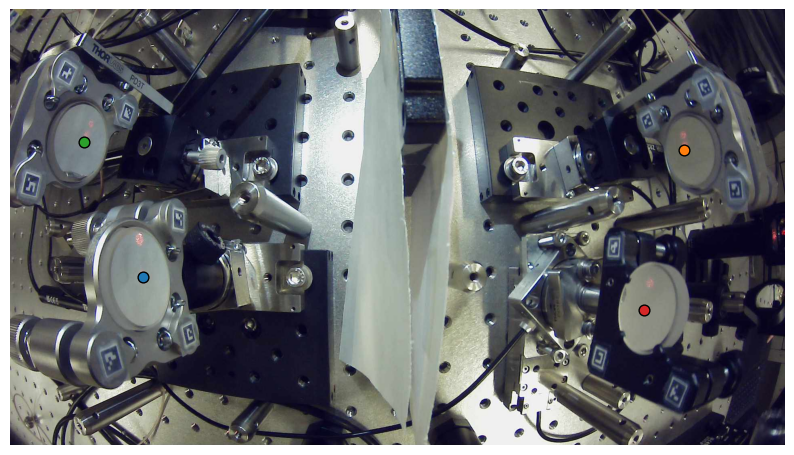

In [24]:
img_path = "WIN_20251120_19_42_16_Pro.jpg"
img_bgr = cv.imread(img_path)
img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
#img_rgb = cv.rotate(img_rgb, cv.ROTATE_180)
plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.scatter(M1_C_Px[0], M1_C_Px[1], s=60, edgecolors='black')
plt.scatter(M2_C_Px[0], M2_C_Px[1], s=60, edgecolors='black')
plt.scatter(M3_C_Px[0], M3_C_Px[1], s=60, edgecolors='black')
plt.scatter(M4_C_Px[0], M4_C_Px[1], s=60, edgecolors='black')
plt.axis('off')
plt.show()

In [25]:
M1_C_Re, M2_C_Re, M3_C_Re, M4_C_Re

(array([-2.65720102, -0.94574237,  4.07215653]),
 array([3.52701492, 0.48422789, 4.12946064]),
 array([-3.92303571,  0.59463954,  4.13036456]),
 array([ 2.43594015, -1.39754469,  4.014568  ]))

In [26]:
def to_sim(M1_C_Re, M2_C_Re, M3_C_Re, M4_C_Re):
    calib_M1 = np.array([-160,-109])
    M1_sim = np.array([-2.5, M1_C_Re[1]])
    M1_sim = M1_sim * 25.4
    diff = calib_M1 - M1_sim
    M1_to_sim = -(M1_sim + diff)

    M2_sim = np.array([M2_C_Re[0], M2_C_Re[1]]) * 25.4
    M3_sim = np.array([M3_C_Re[0], M3_C_Re[1]]) * 25.4
    M4_sim = np.array([M4_C_Re[0], M4_C_Re[1]]) * 25.4

    M2_to_sim = -(M2_sim + diff)
    M3_to_sim = -(M3_sim + diff)
    M4_to_sim = -(M4_sim + diff)

    return M1_to_sim, M2_to_sim, M3_to_sim, M4_to_sim

In [27]:
to_sim(M1_C_Re, M2_C_Re, M3_C_Re, M4_C_Re)

(array([160., 109.]),
 array([ 6.91382094, 72.67875544]),
 array([196.14510705,  69.87429958]),
 array([ 34.62712021, 120.47577902]))

In [49]:
P1, P2

(array([-2.55104165, -1.59281396,  3.4291    ]),
 array([-2.68949245, -0.29404271,  3.421029  ]))

ANGLES

In [57]:
theta_M1 = math.atan2(P2[1] - P1[1], P2[0] - P1[0])      # radians
theta_deg_M1 = math.degrees(theta_M1)                    # degrees
theta_M2 = math.atan2(P5[1] - P4[1], P5[0] - P4[0])      # radians
theta_deg_M2 = math.degrees(theta_M2)                    # degrees
theta_M3 = math.atan2(P7[1] - P6[1], P7[0] - P6[0])      # radians
theta_deg_M3 = math.degrees(theta_M3)                    # degrees
theta_M4 = math.atan2(P10[1] - P9[1], P10[0] - P9[0])    # radians
theta_deg_M4 = math.degrees(theta_M4)                    # degrees

In [59]:
theta_deg_M1, theta_deg_M2, theta_deg_M3, theta_deg_M4 

(96.08482908553071, -82.34060132527584, 80.75976427930394, -97.62265225812155)